In [1]:
import numpy as np
np.random.seed(2023)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
make_images = False

#n_rows, n_cols, n_channels = 9, 191, 1
#n_rows, n_cols, n_channels = 9, 95, 1
#n_rows, n_cols, n_channels = 9, 47, 1
n_rows, n_cols, n_channels = 9, 63, 1

original_dim = n_rows * n_cols

In [3]:
eta_bins = (0.8, 1.24, 1.56, 1.7, 1.8, 1.98, 2.16, 2.4)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)
#pt_bins = (-0.5, -0.3333, -0.2333, -0.1333, -0.07, 0.07, 0.1333, 0.2333, 0.3333, 0.5)
nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)
superstrip_size = 32

discr_pt_cut_high = 14.

### Import data

In [4]:
class RaggedTensorValue(object):
  # Based on
  #   https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/ragged/ragged_tensor_value.py
  def __init__(self, values, row_splits):
    if not (isinstance(row_splits, (np.ndarray, np.generic)) and
            row_splits.dtype == np.int64 and row_splits.ndim == 1):
      raise TypeError("row_splits must be a 1D int64 numpy array")
    if not isinstance(values, (np.ndarray, np.generic, RaggedTensorValue)):
      raise TypeError("values must be a numpy array or a RaggedTensorValue")
    self._values = values
    self._row_splits = row_splits

  row_splits = property(
      lambda self: self._row_splits,
      doc="""The split indices for the ragged tensor value.""")
  values = property(
      lambda self: self._values,
      doc="""The concatenated values for all rows in this tensor.""")
  dtype = property(
      lambda self: self._values.dtype,
      doc="""The numpy dtype of values in this tensor.""")

  @property
  def shape(self):
    """A tuple indicating the shape of this RaggedTensorValue."""
    return (self._row_splits.shape[0] - 1,) + (None,) + self._values.shape[1:]

  def to_list(self):
    """Returns this ragged tensor value as a nested Python list."""
    if isinstance(self._values, RaggedTensorValue):
      values_as_list = self._values.to_list()
    else:
      values_as_list = self._values.tolist()
    return [
        values_as_list[self._row_splits[i]:self._row_splits[i + 1]]
        for i in range(self._row_splits.shape[0] - 1)
    ]

  def to_array(self):
    """Returns this ragged tensor value as a nested Numpy array."""
    arr = np.empty((self._row_splits.shape[0] - 1,), dtype=np.object)
    for i in range(self._row_splits.shape[0] - 1):
      arr[i] = self._values[self._row_splits[i]:self._row_splits[i + 1]]
    return arr

In [5]:
if make_images:
  infile = '../test7/histos_tbf_displ.2.npz'
  with np.load(infile) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_hits = out_hits.to_array()
    print(out_part.shape, out_hits.shape)

  #infile_omtf = '../test7/histos_tbf_omtf.2.npz'
  #with np.load(infile_omtf) as loaded:
  #  out_part_omtf = loaded['out_part']
  #  out_hits_omtf = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
  #  out_hits_omtf = out_hits_omtf.to_array()
  #  print(out_part_omtf.shape, out_hits_omtf.shape)
  #
  #  out_part = np.vstack((out_part, out_part_omtf))
  #  out_hits_tmp = np.empty((out_hits.shape[0] + out_hits_omtf.shape[0],), dtype=np.object)
  #  out_hits_tmp[:out_hits.shape[0]] = out_hits
  #  out_hits_tmp[out_hits.shape[0]:] = out_hits_omtf
  #  out_hits = out_hits_tmp
  #  print(out_part.shape, out_hits.shape)

### Find mean deflection angles

In [6]:
# Find 'dblstrip' unit
PATTERN_X_SIZE = 128-1
PATTERN_X_CENTRAL = 64-1
PATTERN_X_DIV = 16
PATTERN_X_SECTOR = 5400//PATTERN_X_DIV

# Find 'quadstrip' unit
PATTERN_X_QUAD_SIZE = 64-1
PATTERN_X_QUAD_CENTRAL = 32-1
PATTERN_X_QUAD_DIV = 32
PATTERN_X_QUAD_SECTOR = 5400//PATTERN_X_QUAD_DIV

nlayers = 16

nzones = 7

valid_layers = np.empty(nzones, dtype=np.object)
valid_layers[0] = [0,2,3,4,7,8,10,11]
valid_layers[1] = [0,2,3,4,7,8,9,10,11]
valid_layers[2] = [0,2,3,4,7,8,9,10]
valid_layers[3] = [0,2,3,4,7,8,9,10]
valid_layers[4] = [0,1,2,3,4,5,7,8,9]
valid_layers[5] = [1,2,3,4,5,6,7,8]
valid_layers[6] = [1,2,3,5,6,7,12,13,14]

layer_names = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4',
               'RE1', 'RE2', 'RE3', 'RE4',
               'GE1/1', 'GE2/1', 'ME0',
               'MB1', 'MB2', 'MB3', 'MB4']
assert(len(layer_names) == nlayers)

ordered_layer_names = ['MB1',
                       'ME0', 'GE1/1', 'ME1/1',
                       'MB2',
                       'ME1/2', 'RE1',
                       'GE2/1', 'RE2', 'ME2',
                       'MB3',
                       'ME3', 'RE3',
                       'ME4', 'RE4',
                       'MB4',]
assert(len(ordered_layer_names) == nlayers)

from six.moves import range, zip, map, filter

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return binx.astype(np.int32)

def find_eta_bin_16(eta, bins=(16,0.8,2.4)):
  return _find_bin_fast(np.abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

def find_d0_bin_100(d0, bins=(100,-120,120)):
  return _find_bin_fast(d0, bins)

_get_emtf_layer = lambda x: x[0]

_get_emtf_phi = lambda x: x[1]

def _find_dphi(phi1, phi2):
  dphi = np.float32(0)
  dphi += (phi1 - phi2)
  #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
  dphi /= PATTERN_X_DIV
  dphi = np.round(dphi)
  return dphi.astype(np.int32)

def _find_dphi_quad(phi1, phi2):
  dphi = np.float32(0)
  dphi += (phi1 - phi2)
  #dphi /= (np.sinh(1.8587) / np.sinh(np.abs(part_eta)))
  dphi /= PATTERN_X_QUAD_DIV
  dphi = np.round(dphi)
  return dphi.astype(np.int32)

In [7]:
patterns_match_me2_0 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)
patterns_match_me3_0 = np.zeros((100, 16, nlayers, PATTERN_X_SIZE), dtype=np.int32)

def analysis(verbose=1):

  # Loop over part and hits
  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec) = part
    zone = zone.astype(np.int32)

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    if np.abs(1.0/part_invpt) < discr_pt_cut_high:  # require pT > 14
      ievt += 1
      continue
    ipt100 = find_d0_bin_100(part_d0)  # binned by d0 instead

    amap = {}  # emtf_layer -> hit

    for ihit, hit in enumerate(hits):
      amap.setdefault(_get_emtf_layer(hit), []).append(ihit)

    for k, v in amap.iteritems():
      ihit = np.random.choice(v)  # pick a random hit for each emtf_layer
      amap[k] = hits[ihit]

    # Make pair of hits
    for k, v in amap.iteritems():
      emtf_layer = k
      hit1 = v
      hit_phi1 = _get_emtf_phi(hit1)

      # w.r.t ME2
      emtf_layer_me2 = 2
      hit2 = amap.get(emtf_layer_me2, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi(hit_phi1, hit_phi2)
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me2_0[ind] += 1

        # Debug
        if ievt < 10:
          print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi

      # w.r.t ME3
      emtf_layer_me3 = 3
      hit2 = amap.get(emtf_layer_me3, None)
      if hit2 is not None:
        hit_phi2 = _get_emtf_phi(hit2)
        dphi = _find_dphi(hit_phi1, hit_phi2)
        dphi = np.clip(dphi, -PATTERN_X_CENTRAL, PATTERN_X_CENTRAL)
        ind = (ipt100, ieta16, emtf_layer, dphi+PATTERN_X_CENTRAL)
        patterns_match_me3_0[ind] += 1

    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return

In [8]:
%%time

if make_images:
  # Run analysis
  analysis()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [9]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

<div>
  <div title="#1f77b4" style="background: #1f77b4; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ff7f0e" style="background: #ff7f0e; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#2ca02c" style="background: #2ca02c; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#d62728" style="background: #d62728; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#9467bd" style="background: #9467bd; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#8c564b" style="background: #8c564b; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#e377c2" style="background: #e377c2; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#7f7f7f" style="background: #7f7f7f; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#bcbd22" style="background: #bcbd22; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#17becf" style="background: #17becf; display: inline-block; width: 28px; height: 28px;"></div>
  <br/>
  <div title="#aec7e8" style="background: #aec7e8; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ffbb78" style="background: #ffbb78; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#98df8a" style="background: #98df8a; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#ff9896" style="background: #ff9896; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c5b0d5" style="background: #c5b0d5; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c49c94" style="background: #c49c94; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#f7b6d2" style="background: #f7b6d2; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#c7c7c7" style="background: #c7c7c7; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#dbdb8d" style="background: #dbdb8d; display: inline-block; width: 28px; height: 28px;"></div>
  <div title="#9edae5" style="background: #9edae5; display: inline-block; width: 28px; height: 28px;"></div>
</div>

In [10]:
if make_images:
  # Make probability
  patterns_match_me2_1 = patterns_match_me2_0.astype(np.float32)
  patterns_match_me3_1 = patterns_match_me3_0.astype(np.float32)

  # Fix issues due to gap between ME2/1 & ME2/2 at eta=1.6
  # eta 1.5-1.6 -> 7
  # eta 1.6-1.7 -> 8
  patterns_match_me2_1[:,6,:,:] += patterns_match_me2_0[:,7,:,:]
  patterns_match_me2_1[:,7,:,:] += patterns_match_me2_0[:,6,:,:]
  patterns_match_me2_1[:,8,:,:] += patterns_match_me2_0[:,9,:,:]
  patterns_match_me2_1[:,9,:,:] += patterns_match_me2_0[:,8,:,:]

  # Fix issues due to gap between ME3/1 & ME3/2 at eta=1.7
  # eta 1.6-1.7 -> 8
  # eta 1.7-1.8 -> 9
  patterns_match_me3_1[:,7,:,:] += patterns_match_me3_0[:,8,:,:]
  patterns_match_me3_1[:,8,:,:] += patterns_match_me3_0[:,7,:,:]
  patterns_match_me3_1[:,9,:,:] += patterns_match_me3_0[:,10,:,:]
  patterns_match_me3_1[:,10,:,:] += patterns_match_me3_0[:,9,:,:]
  
  # Fix issues due to beginning of ME1/1 at eta=1.5
  # eta 1.5-1.6 -> 7, emtf_layer = 0
  patterns_match_me2_1[:,7,0,:] += patterns_match_me2_0[:,8,0,:]
  patterns_match_me2_1[:,8,0,:] += patterns_match_me2_0[:,7,0,:]
  patterns_match_me3_1[:,7,0,:] += patterns_match_me3_0[:,8,0,:]
  patterns_match_me3_1[:,8,0,:] += patterns_match_me3_0[:,7,0,:]
  
  patterns_match_me2_1[:,6,0,:] += patterns_match_me2_0[:,8,0,:]
  
  # Fix issues due to end of ME1/2 at eta=1.6
  # eta 1.6-1.7 -> 8, emtf_layer = 1
  patterns_match_me2_1[:,8,1,:] += patterns_match_me2_0[:,7,1,:]
  patterns_match_me2_1[:,7,1,:] += patterns_match_me2_0[:,8,1,:]
  patterns_match_me3_1[:,8,1,:] += patterns_match_me3_0[:,7,1,:]
  patterns_match_me3_1[:,7,1,:] += patterns_match_me3_0[:,8,1,:]
  
  patterns_match_me2_1[:,9,1,:] += patterns_match_me2_0[:,7,1,:]
  
  # Fix issues due to beginning of GE1/1 at eta=1.5
  # eta 1.5-1.6 -> 7, emtf_layer = 9
  patterns_match_me2_1[:,7,9,:] += patterns_match_me2_0[:,8,9,:]
  patterns_match_me2_1[:,8,9,:] += patterns_match_me2_0[:,7,9,:]
  patterns_match_me3_1[:,7,9,:] += patterns_match_me3_0[:,8,9,:]
  patterns_match_me3_1[:,8,9,:] += patterns_match_me3_0[:,7,9,:]
  
  patterns_match_me2_1[:,6,9,:] += patterns_match_me2_0[:,8,9,:]
  
  # Fix issues due to end of RE1/2 at eta=1.6
  # eta 1.6-1.7 -> 8, emtf_layer = 5
  patterns_match_me2_1[:,8,5,:] += patterns_match_me2_0[:,7,5,:]
  patterns_match_me2_1[:,7,5,:] += patterns_match_me2_0[:,8,5,:]
  patterns_match_me3_1[:,8,5,:] += patterns_match_me3_0[:,7,5,:]
  patterns_match_me3_1[:,7,5,:] += patterns_match_me3_0[:,8,5,:]
  
  patterns_match_me2_1[:,9,5,:] += patterns_match_me2_0[:,7,5,:]
  
  # For MB1, ignore eta dependence
  # eta 0.8-1.3 -> 0-4, emtf_layer = 12
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,1,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,2,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,3,12,:]
  patterns_match_me2_1[:,0,12,:] += patterns_match_me2_0[:,4,12,:]
  
  patterns_match_me2_1[:,1,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,2,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,3,12,:] = patterns_match_me2_1[:,0,12,:]
  patterns_match_me2_1[:,4,12,:] = patterns_match_me2_1[:,0,12,:]
  
  # For MB2, ignore eta dependence
  # eta 0.8-1.1 -> 0-2, emtf_layer = 13
  patterns_match_me2_1[:,0,13,:] += patterns_match_me2_0[:,1,13,:]
  patterns_match_me2_1[:,0,13,:] += patterns_match_me2_0[:,2,13,:]
  
  patterns_match_me2_1[:,1,13,:] = patterns_match_me2_1[:,0,13,:]
  patterns_match_me2_1[:,2,13,:] = patterns_match_me2_1[:,0,13,:]
  
  # For ME1 & RE1 in Overlap, ignore eta dependence
  # eta 0.8-1.0 -> 0-1, emtf_layer = 1 & 5
  for l in (1,5):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    
  # For ME2 & RE2 in Overlap, ignore eta dependence
  # eta 0.8-1.1 -> 0-2, emtf_layer = 2 & 6
  for l in (2,6):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
    
  # For ME3 & RE3 in Overlap, ignore eta dependence
  # eta 0.8-1.2 -> 0-3, emtf_layer = 3 & 7
  for l in (3,7):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,3,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,3,l,:] = patterns_match_me2_1[:,0,l,:]
    
  # For ME4 & RE4 in Overlap, ignore eta dependence
  # eta 0.8-1.3 -> 0-4, emtf_layer = 4 & 8
  for l in (4,8):
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,1,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,2,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,3,l,:]
    patterns_match_me2_1[:,0,l,:] += patterns_match_me2_0[:,4,l,:]
    
    patterns_match_me2_1[:,1,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,2,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,3,l,:] = patterns_match_me2_1[:,0,l,:]
    patterns_match_me2_1[:,4,l,:] = patterns_match_me2_1[:,0,l,:]

In [11]:
if make_images:
  # Normalize
  patterns_match_me2_1_sum = patterns_match_me2_1.sum(axis=-1, keepdims=True)
  patterns_match_me3_1_sum = patterns_match_me3_1.sum(axis=-1, keepdims=True)
  patterns_match_me2_1[(patterns_match_me2_1_sum < 100/5)[...,0]] = 0
  patterns_match_me3_1[(patterns_match_me3_1_sum < 100/5)[...,0]] = 0
  patterns_match_me2_1_sum[patterns_match_me2_1_sum == 0] = 1
  patterns_match_me3_1_sum[patterns_match_me3_1_sum == 0] = 1
  patterns_match_me2_1 /= patterns_match_me2_1_sum
  patterns_match_me3_1 /= patterns_match_me3_1_sum

  # Add up the probabilities
  #patterns_match_me2_2 = 0.5 * (patterns_match_me2_1 + patterns_match_me3_1)
  patterns_match_me2_2 = 0.25 * (3*patterns_match_me2_1 + 1*patterns_match_me3_1)
  
  # But do not add the probabilities in Overlap or for MB1-4
  patterns_match_me2_2[:,0:4,:,:] = patterns_match_me2_1[:,0:4,:,:]
  patterns_match_me2_2[:,:,12:16,:] = patterns_match_me2_1[:,:,12:16,:]
  
  # Reverse dphi
  patterns_match_me2_2 = patterns_match_me2_2[::-1]

  # Sanity check
  print patterns_match_me2_1[50,:,3].sum(axis=-1)
  print patterns_match_me3_1[50,:,2].sum(axis=-1)
  print patterns_match_me2_2[50,:,3].sum(axis=-1)

In [12]:
if make_images:
  # w.r.t ME2
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me2_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me2_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

In [13]:
if make_images:
  # w.r.t ME3
  fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8,8), sharex=True, sharey=True)

  for i in xrange(nlayers):
    for j in xrange(16):  # ieta16
      yy = np.zeros(100, dtype=np.float32) + PATTERN_X_CENTRAL
      for k in xrange(100):  # ipt100
        if patterns_match_me3_1[k,j,i].sum() > 0:
          yy[k] = np.searchsorted(patterns_match_me3_1[k,j,i].cumsum(), 0.5)  # median
      ax = axs[i/4,i%4]
      ax.plot(np.arange(len(yy))+0.5, yy-PATTERN_X_CENTRAL, color=category10a_palette[j])
      ax.set_ylim(-50,50)

  plt.show()

### Find patterns

In [14]:
def analysis2(verbose=1):

  images_0 = np.zeros((out_part.shape[0], nlayers, PATTERN_X_QUAD_SIZE), dtype=np.bool)
  images_1 = np.zeros((out_part.shape[0], nlayers, PATTERN_X_QUAD_SIZE), dtype=np.bool)  # mirror
  labels_0 = np.zeros((out_part.shape[0], 3), dtype=np.float32)
  labels_1 = np.zeros((out_part.shape[0], 3), dtype=np.float32)  # mirror

  # Loop over part and hits
  ievt = 0

  for part, hits in zip(out_part, out_hits):
    if verbose and (ievt % 100000 == 0):  print("Processing event: {0}".format(ievt))

    (part_invpt, part_eta, part_phi, part_d0, zone, endsec) = part
    zone = zone.astype(np.int32)

    ipt100 = find_pt_bin_100(part_invpt)
    ieta16 = find_eta_bin_16(part_eta)

    if np.abs(1.0/part_invpt) < discr_pt_cut_high:  # require pT > 14
      ievt += 1
      continue
    ipt100 = find_d0_bin_100(part_d0)  # binned by d0 instead

    # Part I - find keystrip
    xx = np.zeros(PATTERN_X_SECTOR, dtype=np.float32)

    for ihit, hit in enumerate(hits):
      emtf_layer = _get_emtf_layer(hit)
      hit_phi1 = _get_emtf_phi(hit)
      hit_phi2 = 0
      dphi = _find_dphi(hit_phi1, hit_phi2)
      
      # Ignore MB3, MB4
      if emtf_layer == 14 or emtf_layer == 15:
        continue

      likelihood = patterns_match_me2_2[ipt100, ieta16, emtf_layer]

      ind1 = dphi-PATTERN_X_CENTRAL
      ind2 = dphi+PATTERN_X_CENTRAL+1
      if ind1 < 0:
        xx[:ind2] += likelihood[-ind1:]
      elif ind2 > xx.shape[0]:
        xx[ind1:] += likelihood[:-ind2 + xx.shape[0]]
      else:
        xx[ind1:ind2] += likelihood

      # Debug
      if ievt < 10:
        print ievt, part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, np.argmax(likelihood)-PATTERN_X_CENTRAL

    if xx.sum() == 0:
      keystrip = -1
    else:
      keystrip = np.argmax(xx)  # max likelihood
      keystrip *= PATTERN_X_DIV

      # Add some noise to keystrip
      sigma = PATTERN_X_DIV/np.sqrt(12)
      sigma *= 1.5  # arbitrary scale factor
      noise = sigma * np.random.normal()
      noise = np.round(noise)
      noise = noise.astype(np.int32)
      keystrip += noise

    # Part II - make image
    if keystrip >= 0:
      img0 = np.zeros((nlayers, PATTERN_X_QUAD_SIZE), dtype=np.bool)
      img1 = np.zeros((nlayers, PATTERN_X_QUAD_SIZE), dtype=np.bool)  # mirror

      for ihit, hit in enumerate(hits):
        emtf_layer = _get_emtf_layer(hit)
        hit_phi1 = _get_emtf_phi(hit)
        hit_phi2 = keystrip
        dphi = _find_dphi_quad(hit_phi1, hit_phi2)

        row = emtf_layer
        col = dphi
        if -PATTERN_X_QUAD_CENTRAL <= col <= PATTERN_X_QUAD_CENTRAL:
          img0[row, +col+PATTERN_X_QUAD_CENTRAL] = 1
          img1[row, -col+PATTERN_X_QUAD_CENTRAL] = 1

        # Debug
        if ievt < 10:
          print '..', part_invpt, part_eta, emtf_layer, hit_phi1, hit_phi2, dphi, keystrip, col

      images_0[ievt] = img0
      images_1[ievt] = img1
      labels_0[ievt] = (part_invpt, part_d0, zone)
      labels_1[ievt] = (-part_invpt, -part_d0, zone)
      # end if keystrip >= 0

    ievt += 1
    # end loop over part and hits

  if verbose: print "DONE"
  return np.concatenate((images_0, images_1)), np.concatenate((labels_0, labels_1))

In [15]:
%%time

if make_images:
  # Run analysis
  images, labels = analysis2()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [16]:
if make_images:
  outfile = 'keras_logs/myimages_displ_out.npz'
  np.savez_compressed(outfile, images=images, labels=labels)

In [17]:
if not make_images:
  infile = 'keras_logs/myimages_displ_out.5.npz'
  with np.load(infile) as loaded:
    images = loaded['images']
    labels = loaded['labels']

### Training

In [18]:
def load_dataset():
  labels_valid = (labels[:, 0] != 0)

  labels_zone = labels[:, 2].astype(np.int32)
  zone_sel = (labels_zone == zone) & (labels_valid)
  if zone == 3:
    zone_sel |= (labels_zone == 4)
  elif zone == 4:
    zone_sel |= (labels_zone == 3)

  zimages = images[zone_sel]
  zlabels = labels[zone_sel]
  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  # Hack to make n_rows == 9
  while len(zlayers) < 9:
    zlayers += [15]  # MB4 layer is always empty

  zimages = zimages[:, zlayers]
  zimages = zimages[:,:,:,np.newaxis]
  zimages = zimages.astype(np.float32)
  print(zimages.shape, zimages.dtype, zlabels.shape, zlabels.dtype)
  assert(original_dim == zimages.shape[1] * zimages.shape[2])
  zimages = zimages.reshape([-1, original_dim])

  nentries = zimages.shape[0]
  x_train, x_test, y_train, y_test = zimages[:nentries//2], zimages[nentries//2:], zlabels[:nentries//2], zlabels[nentries//2:]
  print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
  return x_train, x_test, y_train, y_test

In [19]:
patterns_phi = np.zeros((len(pt_bins)-1, len(eta_bins)-1, nlayers, 3), dtype=np.int32)

from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
#my_cmap = plt.cm.viridis
my_cmap = blue_hot
my_cmap.set_under('k')
vmin = 1e-4
eps = 1e-7

def draw_images():
  x_train_tmp = x_train[np.abs(1.0/y_train[:, 0]) > discr_pt_cut_high]
  y_train_tmp = y_train[np.abs(1.0/y_train[:, 0]) > discr_pt_cut_high]
  x_test_tmp = x_test[np.abs(1.0/y_test[:, 0]) > discr_pt_cut_high]
  y_test_tmp = y_test[np.abs(1.0/y_test[:, 0]) > discr_pt_cut_high]

  # (i) Average of all images
  img = np.zeros((n_rows * n_cols,), dtype=np.float32)
  img += (x_train_tmp.sum(axis=0)) 
  img += (x_test_tmp.sum(axis=0))
  print zone, (x_train_tmp.shape[0] + x_test_tmp.shape[0]), img.min(), img.max()
  img /= img.max()
  img = img.reshape((n_rows, n_cols))

  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  fig, ax = plt.subplots(1, 1, figsize=(4,3.2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  cbar = fig.colorbar(cs)
  cbar.set_ticks(LogLocator())
  plt.yticks(np.arange(len(zlayers)), [layer_names[x] for x in zlayers], fontsize=10)
  plt.show()

  # (ii) Random pick of 16 images
  n = 4
  ind = np.random.randint(x_train_tmp.shape[0], size=n*n)
  img = np.zeros((n_rows * n, n_cols * n), dtype=np.float32)

  for i in xrange(n):
    for j in xrange(n):
      random_img = x_train_tmp[ind[(i*n)+j]].reshape((n_rows, n_cols))
      img[i*n_rows:(i+1)*n_rows, j*n_cols:(j+1)*n_cols] = random_img

  fig, ax = plt.subplots(1, 1, figsize=(6,6), tight_layout=True)
  cs = ax.imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=blue_hot, vmin=0, vmax=1.6)
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n*n_rows], color='w', linewidth=0.5, alpha=0.6)
    ax.plot([-0.5,-0.5+n*n_cols], [-0.5+i*n_rows,-0.5+i*n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

  # (iii) Binned by pT
  n = 9  # num of pt bins
  edges = np.linspace(0.05, 0.95, num=n+1)
  #if zone in (0,1,):
  #  edges[:] = [-0.5, -0.32, -0.22, -0.13, -0.085, 0.085, 0.13, 0.22, 0.32, 0.5]
  #elif zone in (2,3,4,):
  #  edges[:] = [-0.4, -0.29, -0.20, -0.12, -0.08, 0.08, 0.12, 0.20, 0.29, 0.4]
  #elif zone in (5,):
  #  edges[:] = [-0.33, -0.23, -0.14, -0.09, -0.04, 0.04, 0.09, 0.14, 0.23, 0.33]
  #elif zone in (6,):
  #  edges[:] = [-0.25, -0.15, -0.11, -0.07, -0.035, 0.035, 0.07, 0.11, 0.15, 0.25]

  if zone in (0,1,):
    edges[:] = [-120, -84, -60, -36, -12, 12, 36, 60, 84, 120]
  elif zone in (2,3,4,):
    edges[:] = [-120, -88, -62, -38, -14, 14, 38, 62, 88, 120]
  elif zone in (5,):
    edges[:] = [-120, -88, -66, -44, -18, 18, 44, 66, 88, 120]
  elif zone in (6,):
    edges[:] = [-120, -88, -66, -44, -18, 18, 44, 66, 88, 120]

  if zone in (0,1,):
    emtf_layer_me1 = 0
    act = 0.06
  elif zone in (2,3,4):
    emtf_layer_me1 = 0
    act = 0.06
  elif zone in (5,):
    emtf_layer_me1 = 1
    act = 0.05
  elif zone in (6,):
    emtf_layer_me1 = 12
    act = 0.04

  me1_row = zlayers.index(emtf_layer_me1)
  #me1_cdf = img[me1_row].cumsum() / img[me1_row].sum()
  #edges_p = np.linspace(0.05, 0.95, num=n+1)

  img = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)
  img_w_mask = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)

  for i in xrange(n):
    #pt_low = float(edges[i])
    #pt_high = float(edges[i+1])
    d0_low = float(edges[-i-2])
    d0_high = float(edges[-i-1])
    
    # Tweak for the highest pt bins
    if i == 3:
      #pt_high = 0.02
      d0_low = 6
    elif i == 4:
      pass
    elif i == 5:
      #pt_low = -0.02
      d0_high = -6
    
    pt_img = np.zeros((n_rows * n_cols,), dtype=np.float32)
    #pt_sel = (pt_low <= y_train_tmp[:, 0]) & (y_train_tmp[:, 0] <= pt_high)
    #pt_img += (x_train_tmp[pt_sel]).sum(axis=0)
    #pt_sel = (pt_low <= y_test_tmp[:, 0]) & (y_test_tmp[:, 0] <= pt_high)
    #pt_img += (x_test_tmp[pt_sel]).sum(axis=0)
    d0_sel = (d0_low <= y_train_tmp[:, 1]) & (y_train_tmp[:, 1] <= d0_high)
    pt_img += (x_train_tmp[d0_sel]).sum(axis=0)
    d0_sel = (d0_low <= y_test_tmp[:, 1]) & (y_test_tmp[:, 1] <= d0_high)
    pt_img += (x_test_tmp[d0_sel]).sum(axis=0)
    pt_img /= pt_img.max()
    pt_img = pt_img.reshape((n_rows, n_cols))
    img[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img

    pt_img_mask = pt_img.copy()
    #norm = pt_img_mask.sum(axis=-1, keepdims=True)
    norm = np.sqrt(np.square(pt_img_mask).sum(axis=-1, keepdims=True))
    #norm = np.power(np.power(pt_img_mask, 3).sum(axis=-1, keepdims=True), 1./3)
    assert(np.isfinite(norm).all())
    norm[norm == 0] = 1
    pt_img_mask /= norm
    #print i, pt_img_mask
    pt_img_mask = np.where(pt_img_mask < act, 0, 1)
    #img_w_mask[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img * pt_img_mask

    # Write out patterns
    for j in xrange(len(zlayers)):
      _cdf = pt_img[j].cumsum() / pt_img[j].sum()
      _median = np.searchsorted(_cdf, 0.5)
      _valid = np.nonzero(pt_img_mask[j])[0]
      _window = np.asarray([_valid[0], _median, _valid[-1]])
      _window -= PATTERN_X_QUAD_CENTRAL
      _patt = (i, zone, zlayers[j])
      patterns_phi[_patt] = _window
      #print _patt, _window
      if not ((_window[2] - _window[0]) == len(_valid) - 1):
        print("[WARNING] The range is not continuous. Please check!")
        print _patt, _window, _valid
      if not (_window[0] <= _window[1] <= _window[2]):
        print("[WARNING] Median not included in the window. Please check!")

    # Additional fixes
    # - Every non-ME2 layer must have a window of at least 2
    # - Every ME2 layer must have a window of exactly 1
    for j in xrange(len(zlayers)):
      if zlayers[j] != 2:  # non-ME2 layer
        _patt = (i, zone, zlayers[j])
        _window = patterns_phi[_patt]
        if _window[0] == 0 and _window[2] == 0:
          if zlayers[j] in (6, 10,) and i <= 3:
            _window[:] = (-1, 0, 0)
            print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
          elif zlayers[j] in (3, 4, 7, 8, 14) and i <= 3:
            _window[:] = (0, 0, 1)
            print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
          elif zlayers[j] in (6, 10,) and i >= 5:
            _window[:] = (0, 0, 1)
            print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
          elif zlayers[j] in (3, 4, 7, 8, 14) and i >= 5:
            _window[:] = (-1, 0, 0)
            print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
          elif i == 4:
            _window[:] = (-1, 0, 1)
            print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
      else:  # ME2 layer
        _patt = (i, zone, zlayers[j])
        _window = patterns_phi[_patt]
        if _window[0] != 0 or _window[2] != 0:
          _window[:] = (0, 0, 0)
          print("[INFO   ] Changed %r window to %r" % (_patt, tuple(_window)))
    # END Additional fixes

    # Modify pt_img_mask after additional fix
    for j in xrange(len(zlayers)):
      _patt = (i, zone, zlayers[j])
      _window = patterns_phi[_patt]
      pt_img_mask[j, :] = 0
      for k in np.arange(_window[0], _window[2]+1):
        pt_img_mask[j, k+PATTERN_X_QUAD_CENTRAL] = 1
    img_w_mask[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img * pt_img_mask

  # Plot
  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img_w_mask + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

In [20]:
def draw_images2():
  x_train_tmp = x_train[np.abs(1.0/y_train[:, 0]) > discr_pt_cut_high]
  y_train_tmp = y_train[np.abs(1.0/y_train[:, 0]) > discr_pt_cut_high]
  x_test_tmp = x_test[np.abs(1.0/y_test[:, 0]) > discr_pt_cut_high]
  y_test_tmp = y_test[np.abs(1.0/y_test[:, 0]) > discr_pt_cut_high]

  # (iv) Binned by ME1 phi
  img = np.zeros((n_rows * n_cols,), dtype=np.float32)
  img += (x_train_tmp.sum(axis=0)) 
  img += (x_test_tmp.sum(axis=0))
  print (x_train_tmp.shape[0] + x_test_tmp.shape[0]), img.min(), img.max()
  img /= img.max()
  img = img.reshape((n_rows, n_cols))

  zlayers = sorted(valid_layers[zone], key=lambda x: ordered_layer_names.index(layer_names[x]))

  n = 9  # num of pt bins

  if zone in (0,1,2,3,4):
    emtf_layer_me1 = 0
  elif zone in (5,):
    emtf_layer_me1 = 1
  elif zone in (6,):
    emtf_layer_me1 = 12
    
  me1_row = zlayers.index(emtf_layer_me1)
  assert(img[me1_row].sum() > 0)
  me1_cdf = img[me1_row].cumsum() / img[me1_row].sum()
  edges_p = np.linspace(0.05, 0.95, num=n+1)
  
  #if zone in (0,1,2,3,4):
  #  edges_p[0] = 0.01
  #  edges_p[-1] = 0.99
  #elif zone in (5,):
  #  edges_p[0] = 0.02
  #  edges_p[-1] = 0.98
  #elif zone in (6,):
  #  edges_p[0] = 0.03
  #  edges_p[-1] = 0.97
  if True:
    edges_p[0] = 0.01
    edges_p[-1] = 0.99
  
  edges = np.searchsorted(me1_cdf, edges_p)  # edges in ME1 phi
  print zone, me1_row, edges

  #h2 = np.zeros((n, 200), dtype=np.float32)  # x: patterns, y: q/pt
  #pt_edges = np.linspace(-0.5, 0.5, num=201) # edges of initial pt bins
  h2 = np.zeros((n, 120), dtype=np.float32)  # x: patterns, y: q/pt
  d0_edges = np.linspace(-120, 120, num=121) # edges of initial d0 bins

  # Loop over pt bins
  for i in xrange(n):
    low = edges[i]
    high = edges[i+1]
    x = x_train_tmp.reshape(-1, n_rows, n_cols)[:, me1_row, low:high+1]
    sel = np.any(x, axis=1)  # used to select pt that corresponds to this ME1 phi bin
    assert(x.shape[0] == sel.shape[0])

    #_bins = len(pt_edges)-1
    #_range = pt_edges[0], pt_edges[-1]
    _bins = len(d0_edges)-1
    _range = d0_edges[0], d0_edges[-1]
    #y = y_train_tmp[sel][:, 0]  # q/pt
    y = y_train_tmp[sel][:, 1]  # d0
    hist, e = np.histogram(y, bins=_bins, range=_range)
    h2[i] += hist

    x = x_test_tmp.reshape(-1, n_rows, n_cols)[:, me1_row, low:high+1]
    sel = np.any(x, axis=1)  # used to select pt that corresponds to this ME1 phi bin
    assert(x.shape[0] == sel.shape[0])

    #y = y_test_tmp[sel][:, 0]  # q/pt
    y = y_test_tmp[sel][:, 1]  # d0
    hist, e = np.histogram(y, bins=_bins, range=_range)
    h2[i] += hist

  h2_argmax = np.argmax(h2, axis=0)
  
  #if zone in (0,1,):
  #  pass
  #elif zone in (2,3,4,):
  #  # Ignore 2.5 GeV and below
  #  h2_argmax[:20] = n+1
  #  h2_argmax[-20:] = n+1
  #elif zone in (5,):
  #  # Ignore 3 GeV and below
  #  h2_argmax[:34] = n+1
  #  h2_argmax[-34:] = n+1
  #elif zone in (6,):
  #  # Ignore 4 GeV and below
  #  h2_argmax[:50] = n+1
  #  h2_argmax[-50:] = n+1

  img = np.zeros((n_rows * 1, n_cols * n), dtype=np.float32)
  new_edges = np.linspace(0.05, 0.95, num=n+1) # final edges in pt

  # Loop over pt bins
  for i in xrange(n):
    #pt_low = (pt_edges[:-1][h2_argmax == i]).min()
    #pt_high = (pt_edges[1:][h2_argmax == i]).max()
    #new_edges[i] = pt_low
    #new_edges[i+1] = pt_high
    d0_low = (d0_edges[:-1][h2_argmax == i]).min()
    d0_high = (d0_edges[1:][h2_argmax == i]).max()
    new_edges[-i-2] = d0_low  # negative correlation
    new_edges[-i-1] = d0_high # negative correlation
    def is_continuous(a):
      a = np.nonzero(a)[0]
      return len(a) == np.max(a) - np.min(a) + 1
    assert(is_continuous(h2_argmax == i))

    pt_img = np.zeros((n_rows * n_cols,), dtype=np.float32)
    #pt_sel = (pt_low <= y_train_tmp[:, 0]) & (y_train_tmp[:, 0] <= pt_high)
    #pt_img += (x_train_tmp[pt_sel]).sum(axis=0)
    #pt_sel = (pt_low <= y_test_tmp[:, 0]) & (y_test_tmp[:, 0] <= pt_high)
    #pt_img += (x_test_tmp[pt_sel]).sum(axis=0)
    d0_sel = (d0_low <= y_train_tmp[:, 1]) & (y_train_tmp[:, 1] <= d0_high)
    pt_img += (x_train_tmp[d0_sel]).sum(axis=0)
    d0_sel = (d0_low <= y_test_tmp[:, 1]) & (y_test_tmp[:, 1] <= d0_high)
    pt_img += (x_test_tmp[d0_sel]).sum(axis=0)
    pt_img /= pt_img.max()
    pt_img = pt_img.reshape((n_rows, n_cols))
    img[0*n_rows:(0+1)*n_rows, i*n_cols:(i+1)*n_cols] = pt_img

  print zone, me1_row, new_edges

  fig, ax = plt.subplots(1, 1, figsize=(4,3.2), tight_layout=True)
  cs = ax.imshow(h2, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=plt.cm.viridis)
  cbar = fig.colorbar(cs)
  plt.show()

  fig, ax = plt.subplots(1, 1, figsize=(9,2), tight_layout=True)
  cs = ax.imshow(img + eps, origin='lower', interpolation='nearest', aspect='auto',
                 cmap=my_cmap, vmin=vmin, norm=LogNorm(vmin=vmin, vmax=1))
  for i in xrange(1,n):
    ax.plot([-0.5+i*n_cols,-0.5+i*n_cols], [-0.5,-0.5+n_rows], color='w', linewidth=0.5, alpha=0.6)
  ax.axis('off')
  plt.show()

((109512, 9, 63, 1), dtype('float32'), (109512, 3), dtype('float32'))
((54756, 567), (54756, 567), (54756, 3), (54756, 3))
0 109512 0.0 87674.0


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


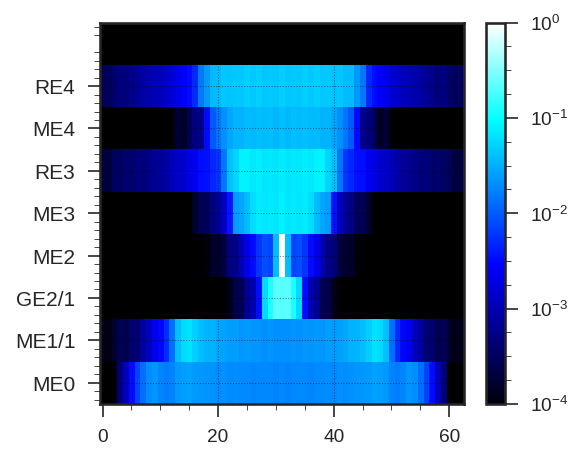

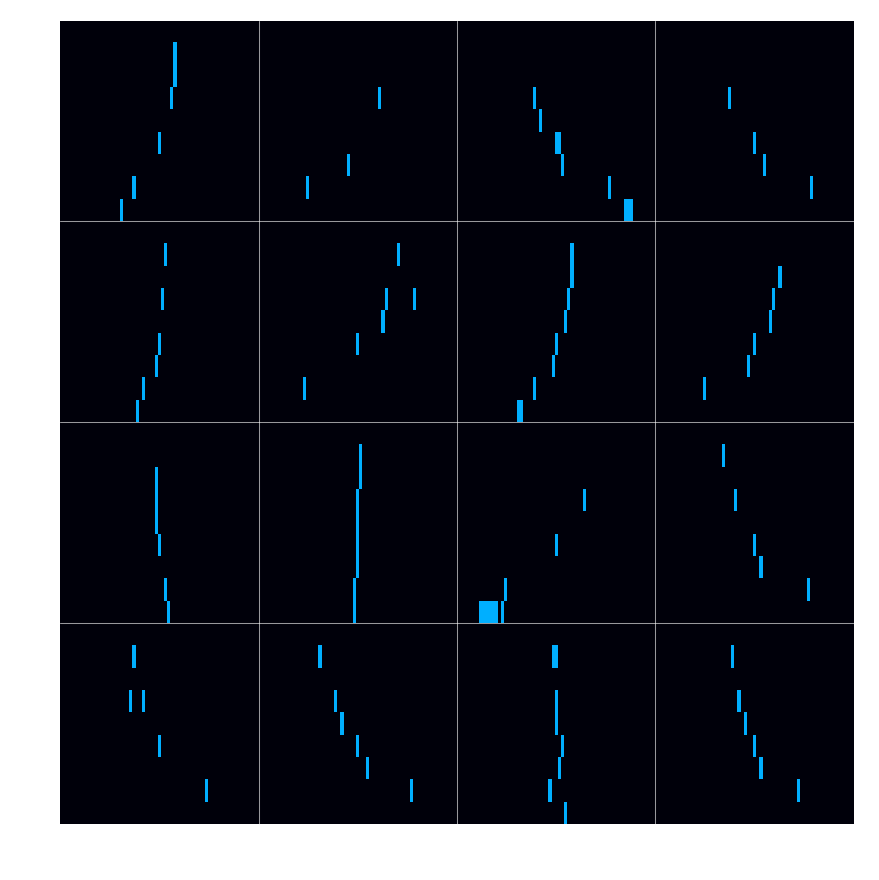

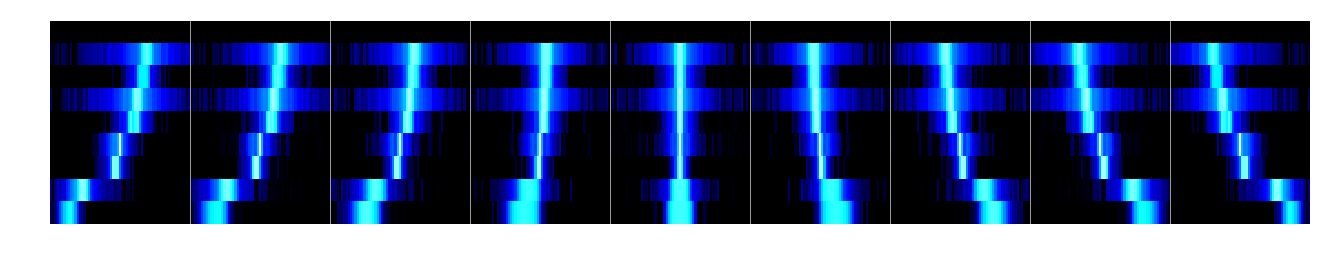

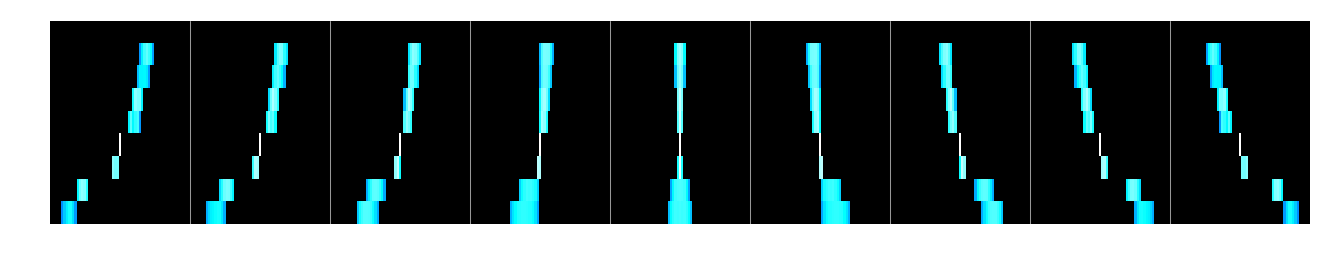

((72410, 9, 63, 1), dtype('float32'), (72410, 3), dtype('float32'))
((36205, 567), (36205, 567), (36205, 3), (36205, 3))
1 72410 0.0 48838.0


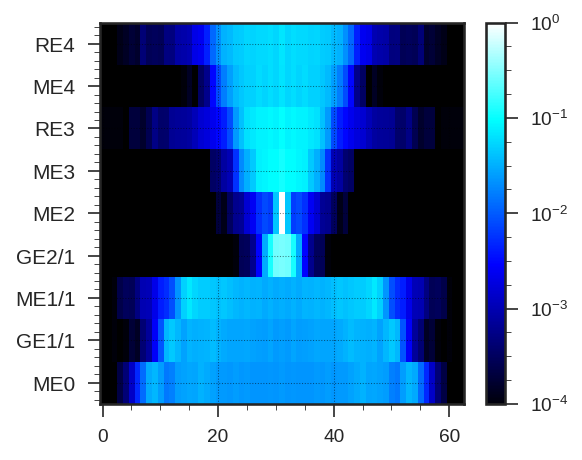

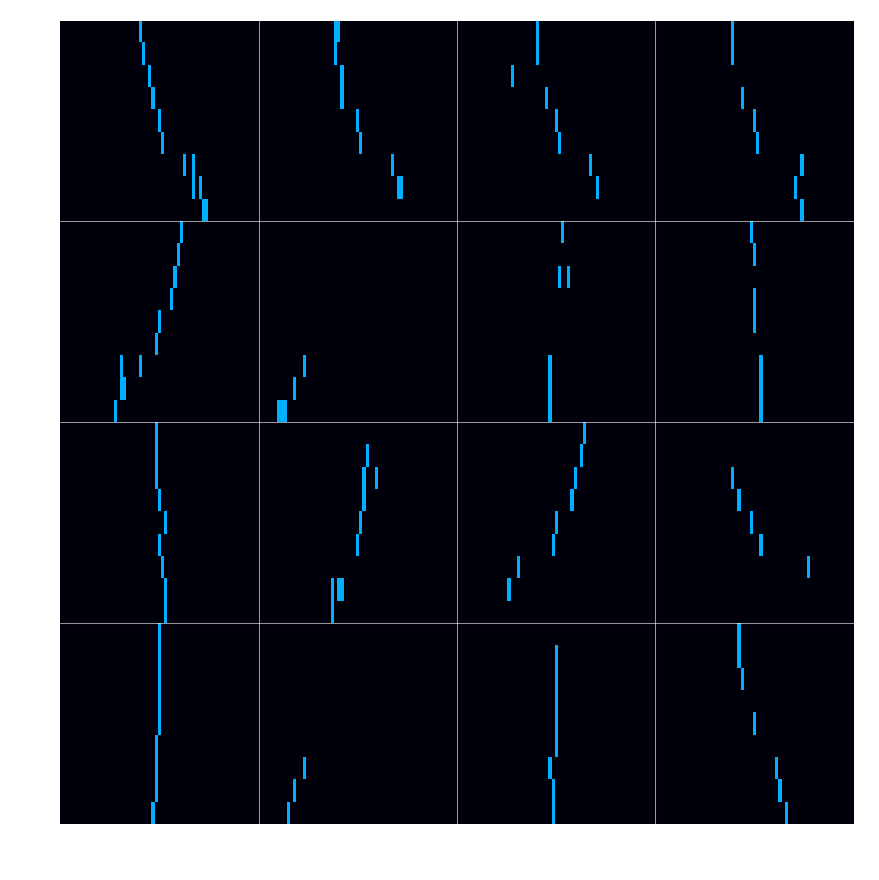

[INFO   ] Changed (3, 1, 2) window to (0, 0, 0)
[INFO   ] Changed (5, 1, 2) window to (0, 0, 0)


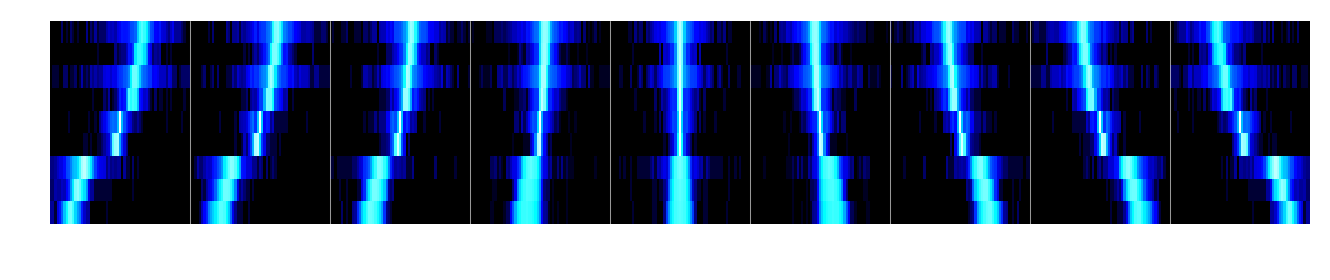

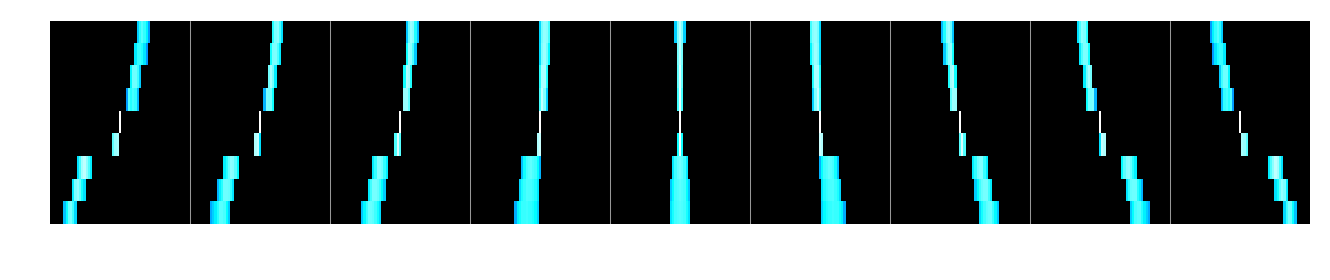

((81426, 9, 63, 1), dtype('float32'), (81426, 3), dtype('float32'))
((40713, 567), (40713, 567), (40713, 3), (40713, 3))
2 81426 0.0 64176.0


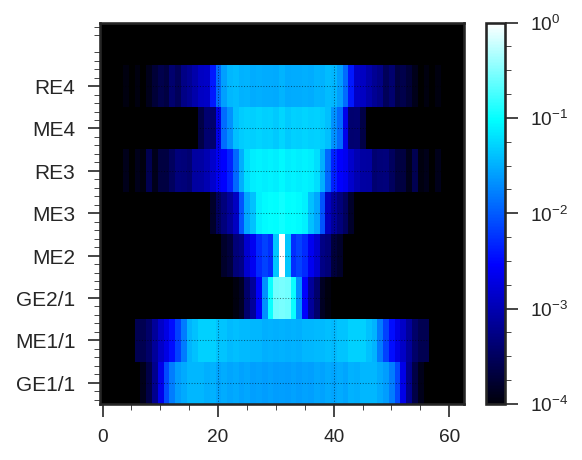

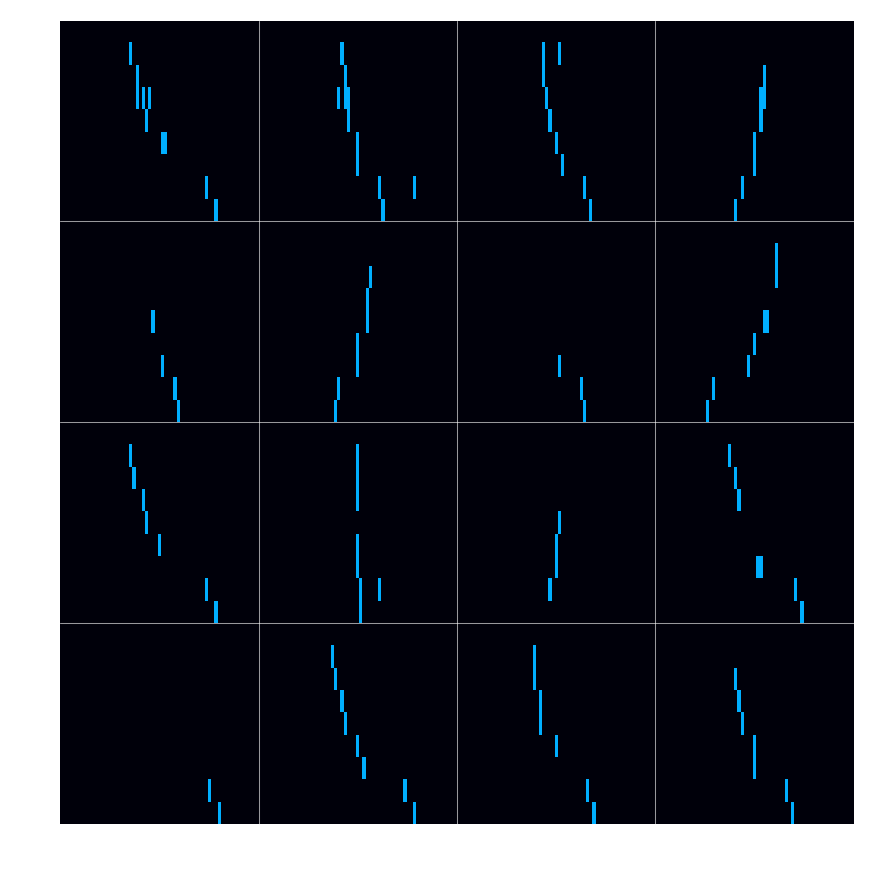

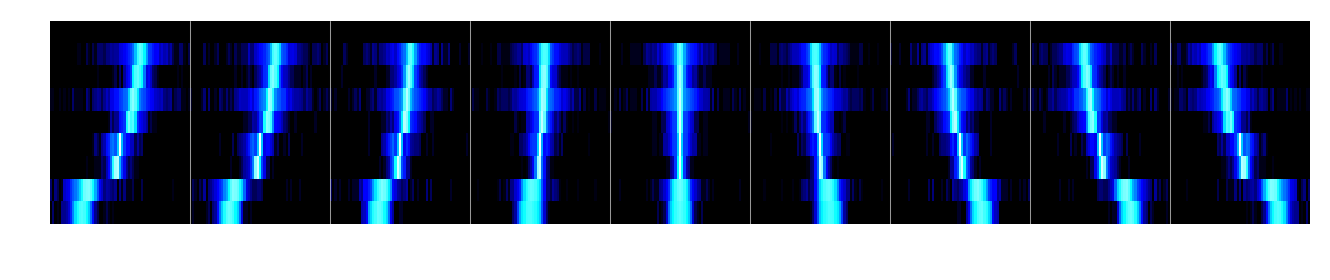

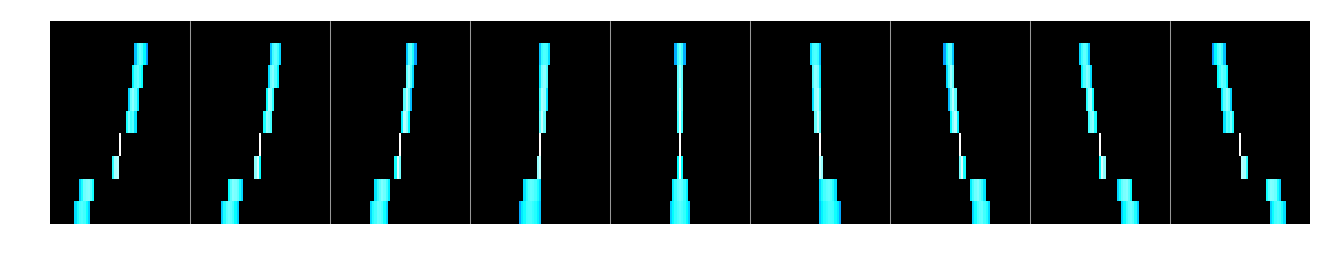

((136928, 9, 63, 1), dtype('float32'), (136928, 3), dtype('float32'))
((68464, 567), (68464, 567), (68464, 3), (68464, 3))
3 136928 0.0 80696.0


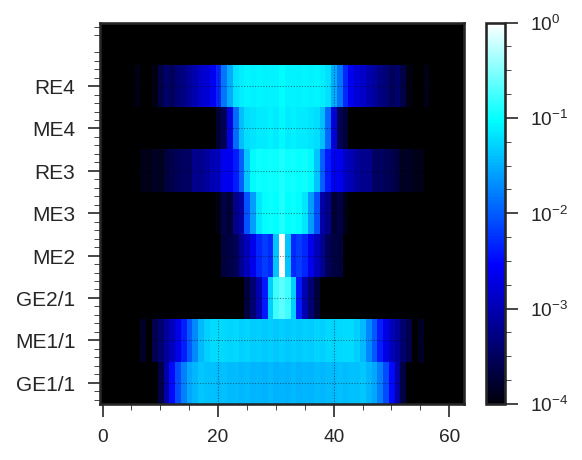

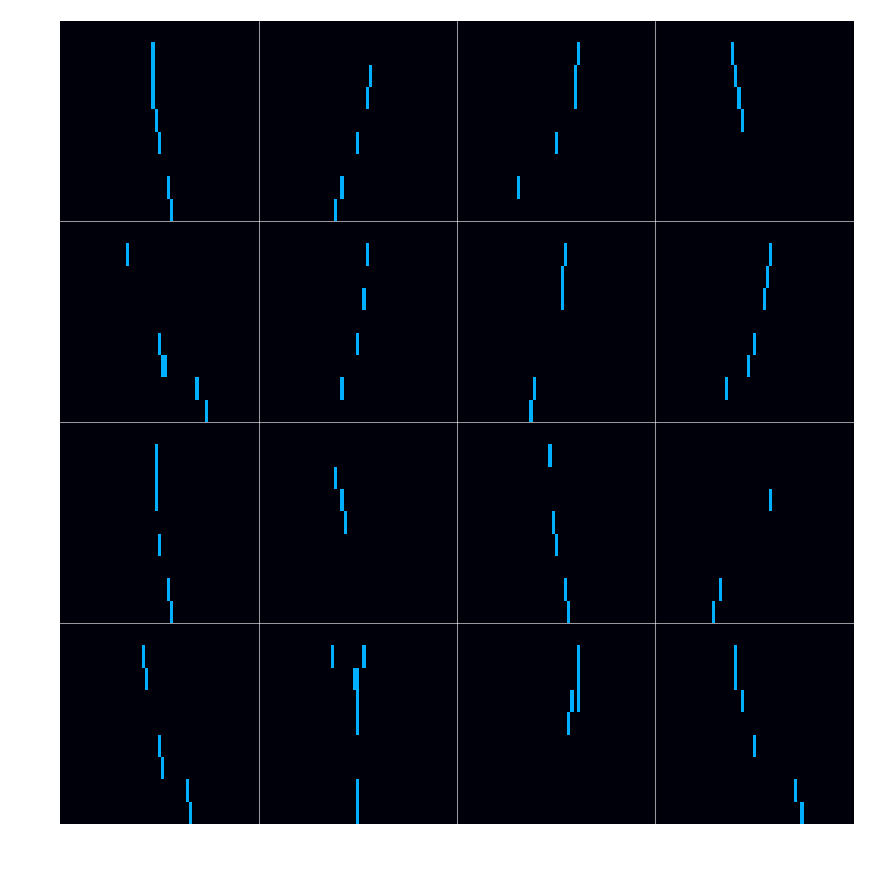

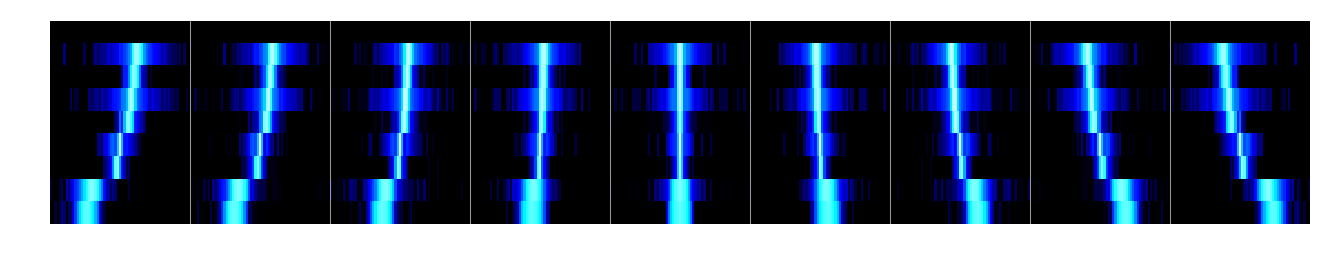

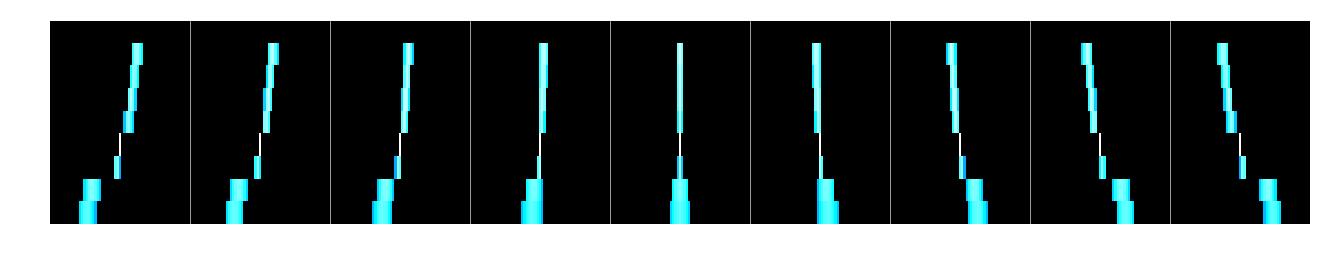

((136928, 9, 63, 1), dtype('float32'), (136928, 3), dtype('float32'))
((68464, 567), (68464, 567), (68464, 3), (68464, 3))
4 136928 0.0 80696.0


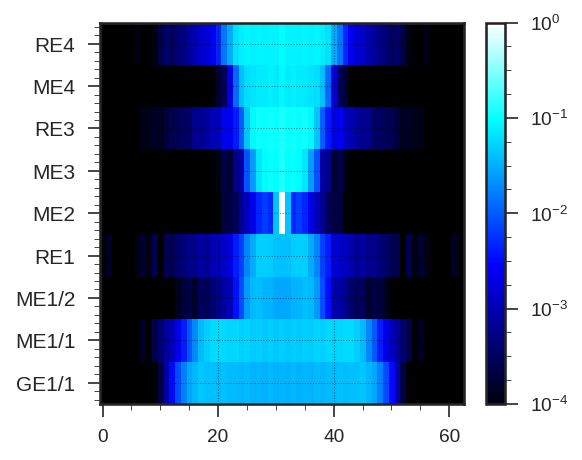

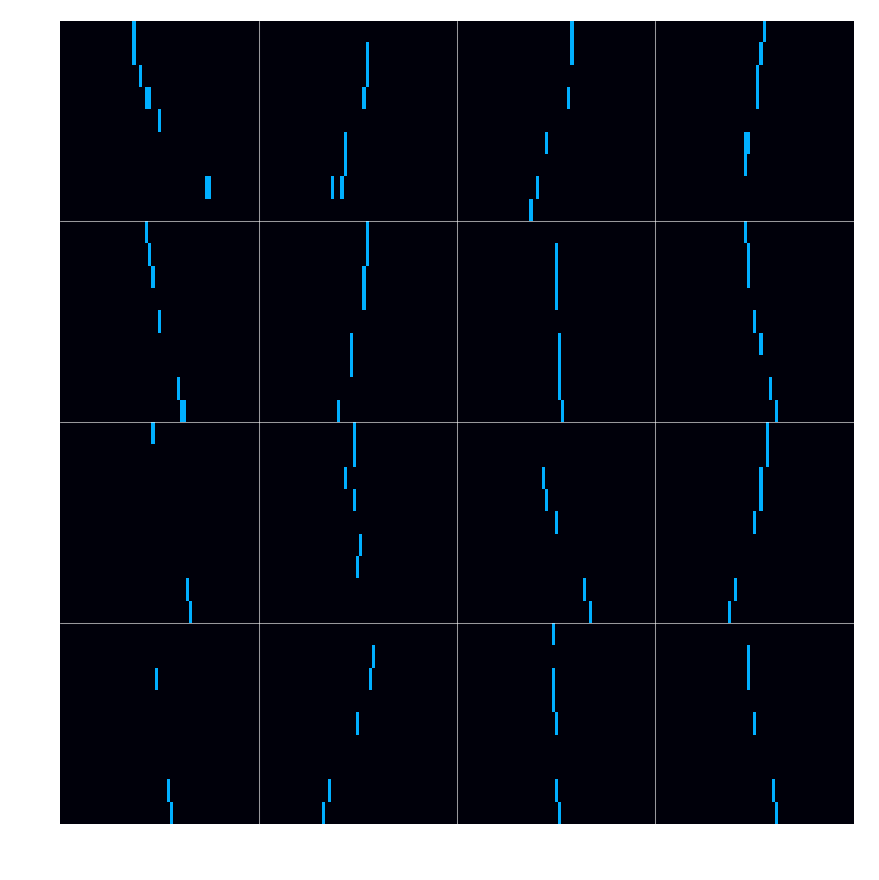

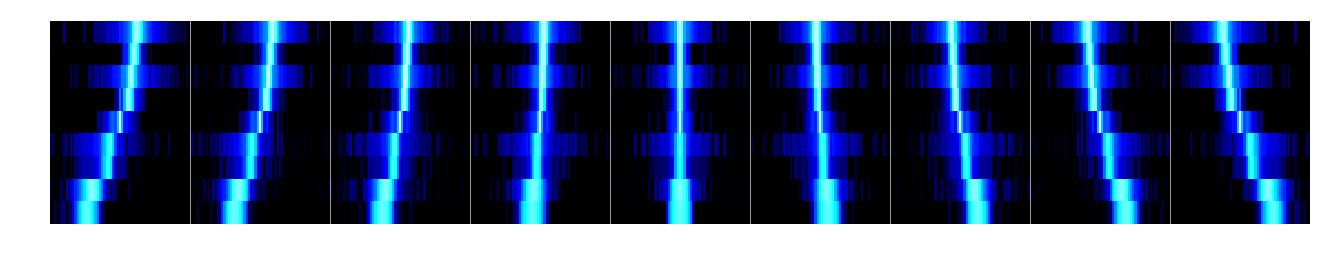

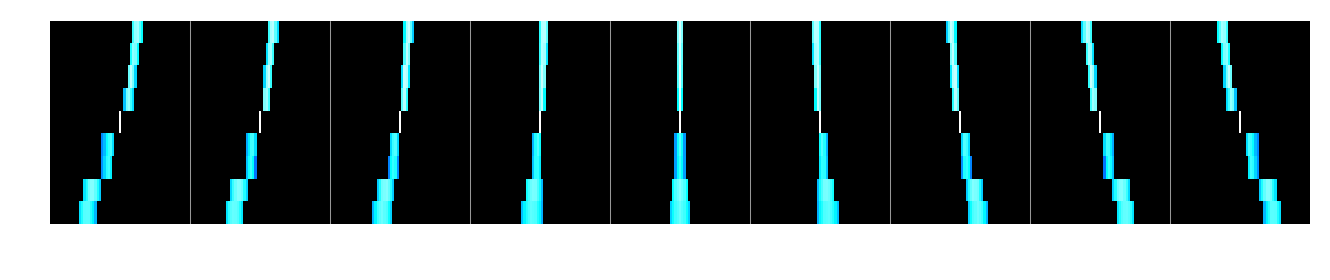

((126964, 9, 63, 1), dtype('float32'), (126964, 3), dtype('float32'))
((63482, 567), (63482, 567), (63482, 3), (63482, 3))
5 126964 0.0 105248.0


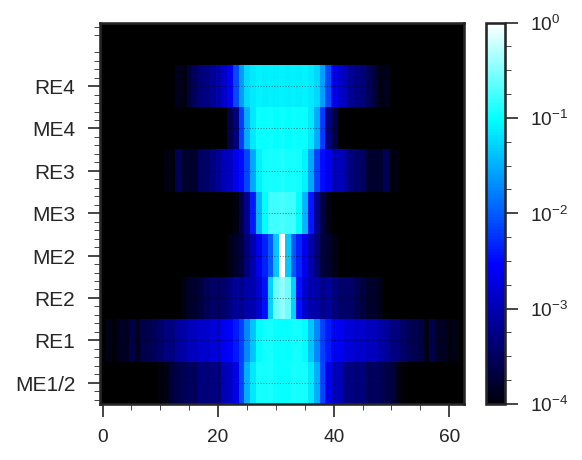

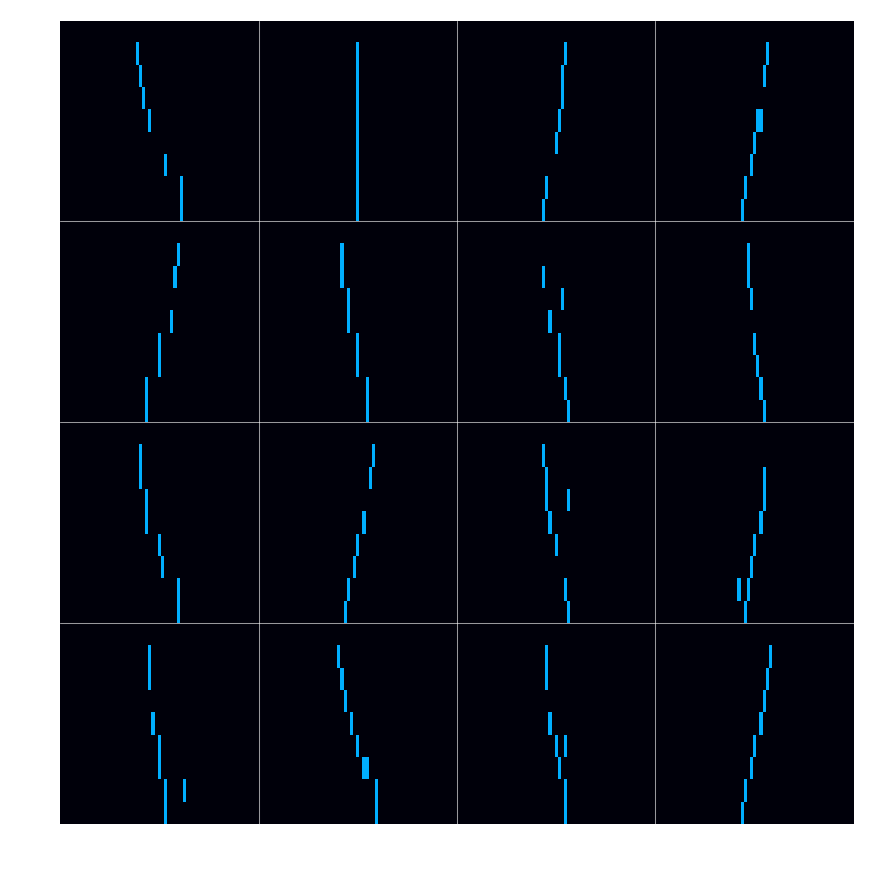

[INFO   ] Changed (2, 5, 2) window to (0, 0, 0)
[INFO   ] Changed (3, 5, 2) window to (0, 0, 0)
[INFO   ] Changed (5, 5, 2) window to (0, 0, 0)
[INFO   ] Changed (6, 5, 2) window to (0, 0, 0)


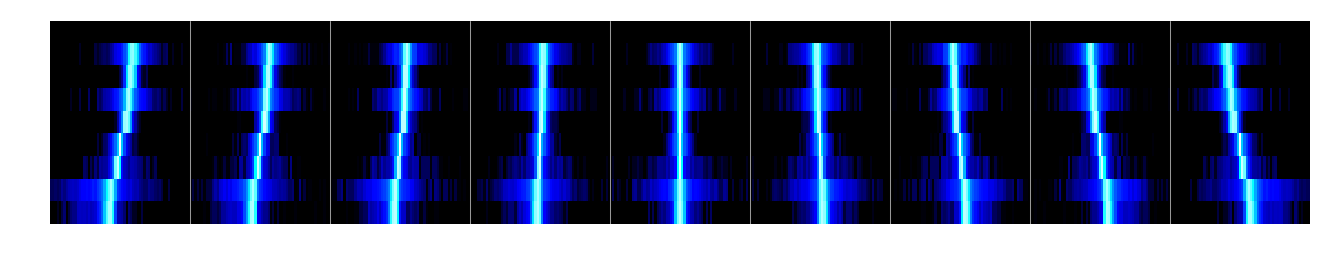

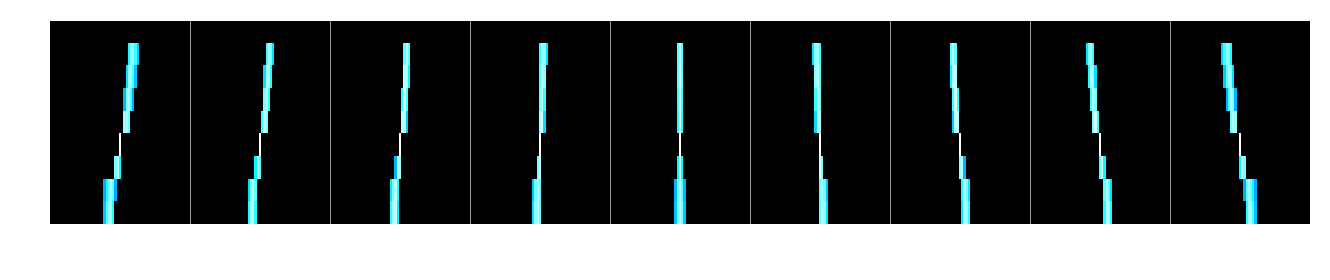

In [21]:
# All zones
for zone in xrange(nzones):

  if zone == 6:
    continue

  # load dataset
  x_train, x_test, y_train, y_test = load_dataset()

  # draw images
  draw_images()

  #draw_images2()

In [22]:
# Patterns
for emtf_layer in xrange(nlayers):
  for ieta in xrange(len(eta_bins)-1):
    for ipt in xrange(len(pt_bins)-1):
      if emtf_layer in valid_layers[ieta]:
        ind = (ipt, ieta, emtf_layer)
        print ind, patterns_phi[ind]
        if emtf_layer != 2 and (patterns_phi[ind][2] - patterns_phi[ind][0]) == 0:
          print("[WARNING] The range is zero. Please check!")

# Save
outfile = 'pattern_bank_displ.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi)

(0, 0, 0) [-19 -17 -15]
(1, 0, 0) [-18 -15 -12]
(2, 0, 0) [-15 -11  -7]
(3, 0, 0) [-9 -5 -1]
(4, 0, 0) [-4  0  4]
(5, 0, 0) [1 5 9]
(6, 0, 0) [ 7 11 15]
(7, 0, 0) [12 15 18]
(8, 0, 0) [15 17 19]
(0, 1, 0) [-19 -16 -13]
(1, 1, 0) [-16 -13 -10]
(2, 1, 0) [-12  -9  -6]
(3, 1, 0) [-8 -4  0]
(4, 1, 0) [-3  0  3]
(5, 1, 0) [0 4 8]
(6, 1, 0) [ 6  9 12]
(7, 1, 0) [10 13 16]
(8, 1, 0) [13 16 19]
(0, 2, 0) [-18 -15 -12]
(1, 2, 0) [-14 -11  -8]
(2, 2, 0) [-11  -8  -5]
(3, 2, 0) [-7 -4  0]
(4, 2, 0) [-3  0  3]
(5, 2, 0) [0 4 7]
(6, 2, 0) [ 5  8 11]
(7, 2, 0) [ 8 11 14]
(8, 2, 0) [12 15 18]
(0, 3, 0) [-16 -13  -9]
(1, 3, 0) [-13 -10  -6]
(2, 3, 0) [-10  -6  -3]
(3, 3, 0) [-6 -3  1]
(4, 3, 0) [-3  0  3]
(5, 3, 0) [-1  3  6]
(6, 3, 0) [ 3  6 10]
(7, 3, 0) [ 6 10 13]
(8, 3, 0) [ 9 13 16]
(0, 4, 0) [-16 -13  -9]
(1, 4, 0) [-13 -10  -6]
(2, 4, 0) [-10  -6  -3]
(3, 4, 0) [-6 -3  1]
(4, 4, 0) [-3  0  3]
(5, 4, 0) [-1  3  6]
(6, 4, 0) [ 3  6 10]
(7, 4, 0) [ 6 10 13]
(8, 4, 0) [ 9 13 16]
(0, 4, 1) [-8 -5 -4

(2, 5, 7) [1 2 3]
(3, 5, 7) [0 1 2]
(4, 5, 7) [-1  0  1]
(5, 5, 7) [-2 -1  0]
(6, 5, 7) [-3 -2 -1]
(7, 5, 7) [-4 -3 -2]
(8, 5, 7) [-6 -4 -2]
(0, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(1, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(2, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(3, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(4, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(5, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(6, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(7, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(8, 6, 7) [0 0 0]
[WARNING] The range is zero. Please check!
(0, 0, 8) [ 9 12 15]
(1, 0, 8) [ 7  9 12]
(2, 0, 8) [4 6 9]
(3, 0, 8) [0 3 6]
(4, 0, 8) [-2  0  2]
(5, 0, 8) [-6 -3  0]
(6, 0, 8) [-9 -6 -4]
(7, 0, 8) [-12  -9  -7]
(8, 0, 8) [-15 -12  -9]
(0, 1, 8) [ 8 10 13]
(1, 1, 8) [ 6  8 10]
(2, 1, 8) [3 5 8]
(3, 1, 8) [0 2 4]
(4, 1, 8) [-2  0  2]
(5, 1, 8) [-4 -2  0]
(